In [22]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from models.arima_forecasts import ARIMA_forecast, find_arima_spec
from models.random_walk import random_walk_forecast
from models.ann import ANN_forecast
from helper_functions import compute_rmse, load_monthly_baci_data, load_daily_baci_data, load_weekly_baci_data, load_daily_exog_data, load_weekly_exog_data, load_monthly_exog_data, load_monthly_exog_data, log_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from models.ann import ANN_diff_forecast
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import PhillipsPerron


# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueWarning)

def ARIMA_vs_RW_vs_ANN(data, 
                       train_ratio=0.86, 
                       steps_ahead=1, 
                       n_forecasts=70, 
                       plot=False, 
                       res=15, 
                       arima_spec=(3, 1, 1),
                       ann_spec=(4, 6),
                       ann_diff=True,
                       exog_diff=True,
                       activation="sigmoid",
                       scaler="robust",
                       epochs=10, 
                       plot_all=True,
                       arima_f=True,
                       ann_f=True,
                       comb_f=True,
                       arimax_f=True,
                       annx_f=True,
                       combx_f=True,
                       exog=None,
                       log=False):


    def plot_forecast(arima_fitted_df, 
                      arima_forecast_df, 
                      rw_forecast_df,
                      ann_fitted_df,
                      ann_forecast_df,
                      train_df,
                      test_df,
                      res=15):
        true_values = pd.concat([train, test])

        # Plot
        plt.figure(figsize=(15,7))

        plt.plot(true_values.index[-res - steps_ahead:], true_values[-res - steps_ahead:].values, color="blue", label='observed')
        plt.plot(arima_fitted_df.index[-res:], arima_fitted_df[-res:].values, color='green', label='ARIMA fitted')
        plt.plot(ann_fitted_df.index[-res:], ann_fitted_df[-res:].values, color='red', label='ANN fitted')
        
        
        # Rename columns of train_df.iloc[-1] to match rw_forecast_df's columns
        # Convert the last value of train_df to a dataframe with the same column name as rw_forecast_df
        renamed_row = pd.DataFrame([arima_fitted_df.values[-1]], columns=arima_forecast_df.columns, index=[arima_fitted_df.index[-1]])
        arima_forecast_df_merged = pd.concat([renamed_row, arima_forecast_df])
    
        renamed_row = pd.DataFrame([ann_fitted_df.values[-1]], columns=ann_forecast_df.columns, index=[ann_fitted_df.index[-1]])
        ann_forecast_df_merged = pd.concat([renamed_row, ann_forecast_df])
      
        renamed_row = pd.DataFrame([train_df.iloc[-1]], columns=rw_forecast_df.columns, index=[train_df.index[-1]])
        rw_forecast_df_merged = pd.concat([renamed_row, rw_forecast_df])


        plt.plot(arima_forecast_df_merged.index, arima_forecast_df_merged.values, color='green', label='ARIMA forecast', linestyle=":")
        plt.plot(rw_forecast_df_merged.index, rw_forecast_df_merged.values, color="purple", label="RW forecast", linestyle=":")
        plt.plot(ann_forecast_df_merged.index, ann_forecast_df_merged.values, color="red", label="ANN forecast", linestyle=":")

        plt.legend()
        plt.show()
        print(f"ARIMA MSE: {compute_rmse(test, arima_forecast_df)}")
        print(f"RW MSE: {compute_rmse(test, rw_forecast_df)}")
        print(f"ANN MSE: {compute_rmse(test, ann_forecast_df)}")




    train_size = int(train_ratio * len(data))
    arima_rmses, arimax_rmses, rw_rmses, ann_rmses, annx_rmses, comb_rmses, combx_rmses =  [], [], [], [], [], [], []
    
    # Initialize empty DataFrames with 'Date' as the index
    columns = ['Forecast']
    first_train_size = train_size
    arima_all_forecasts_df = arimax_all_forecasts_df = rw_all_forecasts_df = ann_all_forecasts_df = annx_all_forecasts_df = comb_all_forecasts_df =combx_all_forecasts_df = pd.DataFrame(columns=columns).set_index(pd.DatetimeIndex([], name='Date'))
    epsilon = 1
    if log:
        for i in range(len(data.columns)):
            data.iloc[:, i] = np.maximum(data.iloc[:, i], 0)
        for i in range(len(exog.columns)):
            exog.iloc[:, i] = np.maximum(exog.iloc[:, i], 0)
        data = data.apply(lambda x: np.log(x+epsilon))
        exog = exog.apply(lambda x: np.log(x+epsilon))
    
    for _ in range(n_forecasts):
   
        print("Forecast number " + str(_ + 1))
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + steps_ahead]
        exog_train = exog.iloc[:train_size]
        exog_test = exog.iloc[train_size: train_size + steps_ahead]

        # Random Walk forecast
        rw_forecast_df = random_walk_forecast(train, test)
        rw_rmse = compute_rmse(test, rw_forecast_df)
        rw_rmses.append(rw_rmse)
        rw_all_forecasts_df = pd.concat([rw_all_forecasts_df, rw_forecast_df])

        if arima_f:
            # ARIMA forecast
            arima_fitted_df, arima_forecast_df, arima_model = ARIMA_forecast(train, 
                                                                            test, 
                                                                            steps_ahead, 
                                                                            p=arima_spec[0], 
                                                                            i=arima_spec[1], 
                                                                            q=arima_spec[2],
                                                                            plot=False,
                                                                            exog=None)
            arima_rmse = compute_rmse(test, arima_forecast_df)
            arima_rmses.append(arima_rmse)
            arima_all_forecasts_df = pd.concat([arima_all_forecasts_df, arima_forecast_df])

        if arimax_f:
            # ARIMAX forecast
            arimax_fitted_df, arimax_forecast_df, arimax_model = ARIMA_forecast(train, 
                                                                            test, 
                                                                            steps_ahead, 
                                                                            p=arima_spec[0], 
                                                                            i=arima_spec[1], 
                                                                            q=arima_spec[2],
                                                                            plot=False,
                                                                            exog=exog)
            #print(arima_forecast_df.values)
            arimax_rmse = compute_rmse(test, arimax_forecast_df)
            arimax_rmses.append(arimax_rmse)
            arimax_all_forecasts_df = pd.concat([arimax_all_forecasts_df, arimax_forecast_df])


        if ann_f:
            # ANN forecast
            ann_fitted_df, ann_forecast_df = ANN_diff_forecast(train=train, 
                                                        test=test, 
                                                        steps_ahead=steps_ahead,
                                                        lookback=ann_spec[0],
                                                        hidden_units=ann_spec[1],
                                                        activation=activation,
                                                        ann_diff=ann_diff,
                                                        scaler=scaler,
                                                        epochs=epochs)
            ann_rmse = compute_rmse(test, ann_forecast_df)
            ann_rmses.append(ann_rmse)
            ann_all_forecasts_df = pd.concat([ann_all_forecasts_df, ann_forecast_df])
        
        if annx_f:
             # ANNX forecast
            annx_fitted_df, annx_forecast_df = ANN_diff_forecast(train=train, 
                                                        test=test, 
                                                        steps_ahead=steps_ahead,
                                                        lookback=ann_spec[0],
                                                        hidden_units=ann_spec[1],
                                                        exog_train=exog_train,
                                                        exog_test=exog_test,
                                                        epochs=epochs,
                                                        activation=activation,
                                                        ann_diff=ann_diff,
                                                        exog_diff=exog_diff,
                                                        scaler=scaler,)
            annx_rmse = compute_rmse(test, annx_forecast_df)
            annx_rmses.append(annx_rmse)
            annx_all_forecasts_df = pd.concat([annx_all_forecasts_df, annx_forecast_df])

        if comb_f:
            # Combination forecast
            comb_forecast_df = pd.DataFrame()
            comb_forecast_df["Forecast"] = (ann_forecast_df["Forecast"] + arima_forecast_df["Forecast"]) / 2
            comb_rmse = compute_rmse(test, comb_forecast_df)

            comb_rmses.append(comb_rmse)
            comb_all_forecasts_df = pd.concat([comb_all_forecasts_df, comb_forecast_df])
            
        if combx_f:
            # Combination forecast
            combx_forecast_df = pd.DataFrame()
            combx_forecast_df["Forecast"] = (annx_forecast_df["Forecast"] + arimax_forecast_df["Forecast"]) / 2
            combx_rmse = compute_rmse(test, combx_forecast_df)

            combx_rmses.append(combx_rmse)
            combx_all_forecasts_df = pd.concat([combx_all_forecasts_df, combx_forecast_df])
        

        train_size += steps_ahead

        if plot:
            plot_forecast(arima_fitted_df=arima_fitted_df,
                          arima_forecast_df=arima_forecast_df,
                          rw_forecast_df=rw_forecast_df,
                          ann_fitted_df=ann_fitted_df,
                          ann_forecast_df=ann_forecast_df,
                          train_df=train,
                          test_df=test,
                          res=res)
    if plot_all:
        plt.gca().set_prop_cycle(None)  # Reset color cycle
        plt.plot(data.index[first_train_size:train_size + steps_ahead - 1], data[first_train_size:train_size + steps_ahead - 1].values, color="blue", label='observed')
        plt.gca().set_prop_cycle(None)  # Reset color cycle
        plt.plot(rw_all_forecasts_df.index, rw_all_forecasts_df.values, color='purple', label='RW forecast', linestyle=":")

        if arima_f:
            plt.plot(arima_all_forecasts_df.index, arima_all_forecasts_df.values, color='green', label='ARIMA forecast', linestyle=":")
        if ann_f:
            plt.plot(ann_all_forecasts_df.index, ann_all_forecasts_df.values, color='red', label='ANN forecast', linestyle=":")
        if comb_f:
            plt.plot(comb_all_forecasts_df.index, comb_all_forecasts_df.values, color='black', label='ANN/ARIMA combination', linestyle=":")
        if arimax_f:
            plt.plot(arimax_all_forecasts_df.index, arimax_all_forecasts_df.values, color='brown', label='ARIMAX forecast', linestyle=":")
        if annx_f:
            plt.plot(annx_all_forecasts_df.index, annx_all_forecasts_df.values, color='pink', label='ANNX forecast', linestyle=":")


        # Rotate x-axis labels for better clarity
        plt.xticks(rotation=45)

        # Optional: Use fewer date ticks on the x-axis
        #import matplotlib.dates as mdates
        #plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Every week

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())  # Display unique labels only

        plt.tight_layout()  # Adjust the layout for better display
        plt.show()

        


    return arima_rmses, rw_rmses, ann_rmses, comb_rmses, arimax_rmses, annx_rmses, combx_rmses


 ADF p-value:  0.047910178547485215
ADF p-value:  1.454734138022883e-20
ADF p-value:  7.417121481538369e-10
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.571
P-value                         0.006
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.265
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
KPSS Statistic: 0.4431853701157276
P-value: 0.05854078874322086
Num Lags: 10
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Seri

c:\Users\mariumbo\project-thesis\models\arima_forecasts.py:225: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(values.diff().dropna(), regression='c')


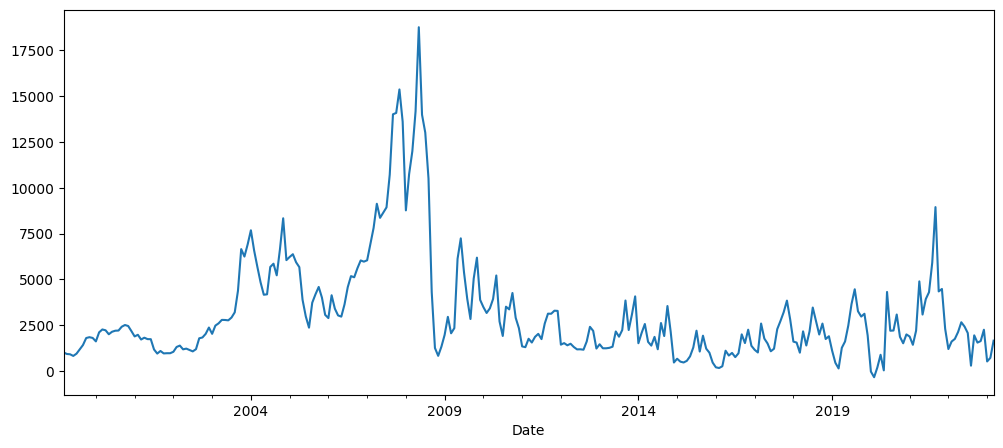

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4896.516, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4898.378, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4898.392, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4894.518, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4894.734, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.574 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2446.259
Date:                Thu, 09 Nov 2023   AIC                           4894.518
Time:                        17:51:57   BIC                           4898.181
Sample:                    03-31-1999   HQIC                          4895.986
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.392e+06   5.91e+04     23.544      0.000    1.28e+06    1.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               406.72
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               3.07   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
data_freq = "monthly"
exog_inc = True
if data_freq == "daily":
    df = load_daily_baci_data()
    if exog_inc:
        exog = load_daily_exog_data()
elif data_freq == "weekly":
    df = load_weekly_baci_data()
    if exog_inc:
        exog = load_weekly_exog_data()
else:
    df = load_monthly_baci_data()
    if exog_inc:
        exog = load_monthly_exog_data()

if exog_inc:
        # Inner join both dataframes on their index to ensure they have the same timestamp
    result = df.join(exog, how='inner', lsuffix='_baci', rsuffix='_ironfut')

    # Split the result back into individual dataframes if needed
    df = result[['CLOSE']]
    exog = result[['IRON_CLOSE', "COAL_CLOSE"]]

    # Rename the columns of the individual dataframes to 'CLOSE'
    df = df.rename(columns={'CLOSE_baci': 'CLOSE'})
        
#df = log_data(df)
#exog = log_data(exog)
find_arima_spec(df)



Forecast number 1
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                  260
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2188.191
Date:                Thu, 09 Nov 2023   AIC                           4382.381
Time:                        17:52:02   BIC                           4393.052
Sample:                    03-31-1999   HQIC                          4386.672
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6941      0.143     -4.852      0.000      -0.974      -0.414
ma.L1          0.8161      0.129      6.349      0.000       0.564       1.068
sigma2      1.276e+06   6.26e+04  

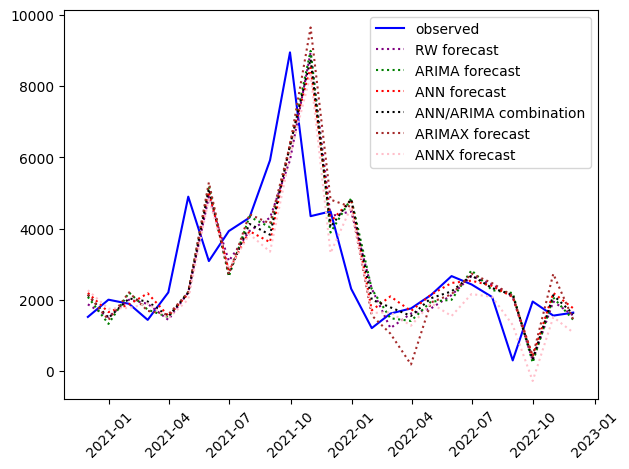

ARIMA RMSEs: 1130.600371909777
ARIMAX RMSEs: 1179.8841453856191
Random Walk RMSEs: 1059.44
ANN RMSEs: 1045.6401330566407
ANNX RMSEs: 1110.8911938476563
Combination RMSEs: 1075.795616655156
ARIMA RW Reduction: 0.06716791126423113
ARIMAX RW Reduction: 0.1136866131027893
ANN RW Reduction: -0.013025623861058057
ANNX RW Reduction: 0.04856451884736862
Combination RW Reduction: 0.015437982948686028


In [29]:
train_ratio = 0.90
n_forecasts = 25
steps_ahead = 1
res = 200
arima_spec = (1, 1, 1)
ann_spec = (4, 2)
epochs = 50
plot = False
plot_all = True
res = 50
exog = exog
activation = "sigmoid"
ann_diff = True
exog_diff = False
scaler = "standard"
arima_f, arimax_f, ann_f, annx_f, comb_f, combx_f = True, True, True, True, True, True
arima_rmses, rw_rmses, ann_rmses, comb_rmses, arimax_rmses, annx_rmses, combx_rmses = ARIMA_vs_RW_vs_ANN(data=df, 
                                                                res=res, 
                                                                train_ratio=train_ratio,
                                                                n_forecasts=n_forecasts,
                                                                steps_ahead=steps_ahead,
                                                                plot=False,
                                                                plot_all=plot_all,
                                                                arima_spec=arima_spec,
                                                                ann_spec=ann_spec,
                                                                epochs=epochs,
                                                                activation=activation,
                                                                ann_diff=ann_diff,
                                                                exog_diff=exog_diff,
                                                                scaler=scaler,
                                                                exog=exog,
                                                                arima_f=arima_f,
                                                                arimax_f = arimax_f,
                                                                ann_f=ann_f,
                                                                annx_f=annx_f,
                                                                comb_f=comb_f,
                                                                combx_f=combx_f
                                                                )

# Function to calculate RMSE reduction
def calculate_rw_reduction(model_rmses, rw_rmses):
    return 'N/A' if not model_rmses else (np.average(model_rmses) - np.average(rw_rmses)) / np.average(rw_rmses)


# Print statements for the console
print(f"ARIMA RMSEs: {'N/A' if not arima_rmses else np.average(arima_rmses)}")
print(f"ARIMAX RMSEs: {'N/A' if not arimax_rmses else np.average(arimax_rmses)}")
print(f"Random Walk RMSEs: {'N/A' if not rw_rmses else np.average(rw_rmses)}")
print(f"ANN RMSEs: {'N/A' if not ann_rmses else np.average(ann_rmses)}")
print(f"ANNX RMSEs: {'N/A' if not annx_rmses else np.average(annx_rmses)}")
print(f"Combination RMSEs: {'N/A' if not comb_rmses else np.average(comb_rmses)}")
print(f"ARIMA RW Reduction: {calculate_rw_reduction(arima_rmses, rw_rmses)}")
print(f"ARIMAX RW Reduction: {calculate_rw_reduction(arimax_rmses, rw_rmses)}")
print(f"ANN RW Reduction: {calculate_rw_reduction(ann_rmses, rw_rmses)}")
print(f"ANNX RW Reduction: {calculate_rw_reduction(annx_rmses, rw_rmses)}")
print(f"Combination RW Reduction: {calculate_rw_reduction(comb_rmses, rw_rmses)}")





# Open the file in write mode
with open('final_log.txt', 'a') as file:
    print("Monthly Forecast: Train ratio: " + str(train_ratio) + ". " + str(steps_ahead) + " step ahead. " + str(n_forecasts) + " forecasts", file=file)
    print(f"ARIMA RMSEs: {'N/A' if not arima_rmses else np.average(arima_rmses)}", file=file)
    print(f"ARIMAX RMSEs: {'N/A' if not arimax_rmses else np.average(arimax_rmses)}", file=file)
    print(f"Random Walk RMSEs: {'N/A' if not rw_rmses else np.average(rw_rmses)}", file=file)
    print(f"ANN RMSEs: {'N/A' if not ann_rmses else np.average(ann_rmses)}", file=file)
    print(f"ANNX RMSEs: {'N/A' if not annx_rmses else np.average(annx_rmses)}", file=file)
    print(f"Combination RMSEs: {'N/A' if not comb_rmses else np.average(comb_rmses)}", file=file)
    print(f"ARIMA RW Reduction: {calculate_rw_reduction(arima_rmses, rw_rmses)}", file=file)
    print(f"ARIMAX RW Reduction: {calculate_rw_reduction(arimax_rmses, rw_rmses)}", file=file)
    print(f"ANN RW Reduction: {calculate_rw_reduction(ann_rmses, rw_rmses)}", file=file)
    print(f"ANNX RW Reduction: {calculate_rw_reduction(annx_rmses, rw_rmses)}", file=file)
    print(f"Combination RW Reduction: {calculate_rw_reduction(comb_rmses, rw_rmses)}", file=file)



In [ ]:
from numpy import log

def calculate_statistics(df):
    descriptive_stats = {}
    columns = df.columns

    for column in columns:
        # Log transformation
        logged_data = df[column]
        
        # First difference of the logged data
        diff_data = logged_data.diff().dropna()

        # Descriptive statistics for logged data
        logged_descriptive_stats = {
            'N': logged_data.count(),
            'Mean (logged)': logged_data.mean(),
            'Standard Deviation (logged)': logged_data.std(),
            'Skewness (logged)': logged_data.skew(),
            'Kurtosis (logged)': logged_data.kurtosis(),
        }

        # Descriptive statistics for differenced data
        diff_descriptive_stats = {
            'N': diff_data.count(),
            'Mean (differenced)': diff_data.mean(),
            'Standard Deviation (differenced)': diff_data.std(),
            'Skewness (differenced)': diff_data.skew(),
            'Kurtosis (differenced)': diff_data.kurtosis(),
        }

        # Jarque-Bera test on logged data
        jb_stat, jb_pvalue = jarque_bera(logged_data)[:2]

        # Ljung-Box test on logged data for autocorrelation
        lb_value, lb_pvalue = acorr_ljungbox(logged_data, lags=[36], return_df=False)

        # Augmented Dickey-Fuller test on logged data
        adf_stat, adf_pvalue, _, _, _, _ = adfuller(logged_data)

        # Phillips-Perron test on logged data
        pp_test = PhillipsPerron(logged_data)

        # KPSS test on logged data
        kpss_stat, kpss_pvalue, _, _ = kpss(logged_data, regression='c', nlags='auto')

        # ADF, PP, and KPSS tests on differenced data
        adf_stat_diff, adf_pvalue_diff, _, _, _, _ = adfuller(diff_data)
        pp_test_diff = PhillipsPerron(diff_data)
        kpss_stat_diff, kpss_pvalue_diff, _, _ = kpss(diff_data, regression='c', nlags='auto')

        # Consolidate all stats into a single dictionary
        descriptive_stats[column] = {
            **logged_descriptive_stats,
            'Jarque-Bera Statistic (logged)': jb_stat,
            'Jarque-Bera p-value (logged)': jb_pvalue,
            'Ljung-Box Q(36) (logged)': lb_value[0],
            'Ljung-Box p-value (logged)': lb_pvalue[0],
            'ADF Statistic (logged)': adf_stat,
            'ADF p-value (logged)': adf_pvalue,
            'PP Statistic (logged)': pp_test.stat,
            'PP p-value (logged)': pp_test.pvalue,
            'KPSS Statistic (logged)': kpss_stat,
            'KPSS p-value (logged)': kpss_pvalue,
            **diff_descriptive_stats,
            'ADF Statistic (differenced)': adf_stat_diff,
            'ADF p-value (differenced)': adf_pvalue_diff,
            'PP Statistic (differenced)': pp_test_diff.stat,
            'PP p-value (differenced)': pp_test_diff.pvalue,
            'KPSS Statistic (differenced)': kpss_stat_diff,
            'KPSS p-value (differenced)': kpss_pvalue_diff
        }

    return descriptive_stats

# Function to print statistics as comma-separated values
def print_statistics(stats, column_name):
    print(f"\nStatistics for {column_name}: ", end='')
    print(', '.join([f"{stat}: {value:.2f}" if isinstance(value, (int, float)) else f"{stat}: {value}" for stat, value in stats.items()]))


# Main loop
for i in range(3):
    exog_inc = True
    data_freq = ["monthly", "weekly", "daily"][i]
    
    df = globals()[f'load_{data_freq}_baci_data']()
    exog = globals()[f'load_{data_freq}_exog_data']() if exog_inc else pd.DataFrame()

    if exog_inc:
         # Inner join both dataframes on their index to ensure they have the same timestamp
        result = df.join(exog, how='inner', lsuffix='_baci', rsuffix='_ironfut')

        # Split the result back into individual dataframes if needed
        df = result[['CLOSE']]
        exog = result[['IRON_CLOSE', "COAL_CLOSE"]]

        # Rename the columns of the individual dataframes to 'CLOSE'
        df = df.rename(columns={'CLOSE_baci': 'CLOSE'})

    # Calculate and print statistics for df
    df_stats = calculate_statistics(df)
    print_statistics(df_stats, 'BACI data')

    # Calculate and print statistics for exog
    exog_stats = {col: calculate_statistics(exog[[col]]) for col in exog.columns}
    for column in exog.columns:
        print_statistics(exog_stats[column][column], column)